In [ ]:
!pip install tensorflow

X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)
Individual sample: (28, 28) grid


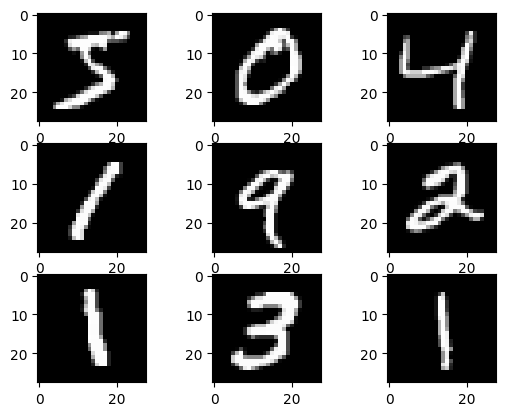

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="True"

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

np.random.seed(8610)
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train: " + str(X_train.shape))
print("y_train: " + str(y_train.shape))
print("X_test: " + str(X_test.shape))
print("y_test: " + str(y_test.shape))
print("Individual sample: " + str(X_train[0].shape) + " grid")

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()


In [ ]:

X_train = X_train / 255.0
X_test = X_test / 255.0


N_train, numRows, numCols = X_train.shape
X_train = np.reshape(X_train, (N_train, numRows * numCols))
N_test = X_test.shape[0]
X_test = np.reshape(X_test, (N_test, numRows * numCols))
print(X_train.shape)
print(X_test.shape)




(60000, 784)
(10000, 784)


In [ ]:
accuracies = {}


In [ ]:
# Converting the labels to a one-hot encoding format
y_train = pd.get_dummies(y_train).values
print(y_train.shape)
print(y_train[:5])


(60000, 10)
[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]


In [ ]:
# Multiclass Logistic Regression Implementation
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def crossEntropy(y, q):
    return -np.vdot(y, np.log(q))

def eval_loss(X, Y, w):
    # assume feature vector are already augmented
    l = 0.0
    N = X.shape[0]
    for i in range(N):
        Xi = X[i]
        Yi = Y[i]
        qi = softmax(w @ Xi)  # probability vector
        l += crossEntropy(Yi, qi)
    return l

def multiclassLogisticRegressionSGD(X, Y, eta, n_epochs):
    # logistic regression based stochastic gradient descent
    N, d = X.shape
    X = np.insert(X, 0, 1, axis = 1)  # augment the feature matrix with a column of ones
    k = Y.shape[1]
    w = np.zeros((k, d + 1))  # initialize the weight as a matrix vector

    loss = []
    for ep in range(n_epochs):
        l = eval_loss(X, Y, w)
        loss.append(l)
        print("epoch is: " + str(ep) + " cost is: " + str(l))
        perm = np.random.permutation(N)  # randomly pick example
        for i in perm:
            Xi = X[i]
            Yi = Y[i]
            qi = softmax(w @ Xi)  # probability vector
            grad_Li = np.outer(qi - Yi, Xi)  # np outer product
            w = w - eta * grad_Li
    return w, loss


epoch is: 0 cost is: 138155.10557972503
epoch is: 1 cost is: 18916.578967565318
epoch is: 2 cost is: 17170.956232758424
epoch is: 3 cost is: 16638.320350849248
epoch is: 4 cost is: 16412.31205253424
epoch is: 5 cost is: 16039.556137002734
epoch is: 6 cost is: 15716.381401782412
epoch is: 7 cost is: 16405.088191243467
epoch is: 8 cost is: 15456.131716593445
epoch is: 9 cost is: 15494.397089059854


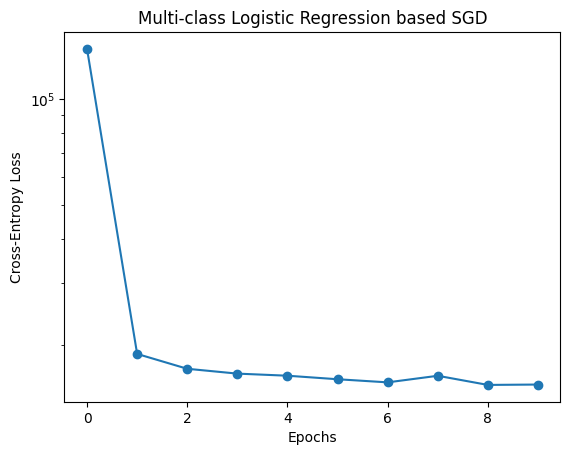

In [ ]:
def predict(X, w):
    X = np.insert(X, 0, 1, axis= 1)
    N = X.shape[0]
    predictions = []
    probabilities = []
    for i in range(N):
        Xi = X[i]
        qi = softmax(w @ Xi)  # probability vector
        k = np.argmax(qi)  # index of highest probability
        predictions.append(k)
        probabilities.append(np.max(qi))  # highest probability

    return predictions, probabilities

eta = 0.01

w, loss = multiclassLogisticRegressionSGD(X_train, y_train, eta, 10)
plt.semilogy(loss, marker='o')
plt.xlabel("Epochs")
plt.ylabel('Cross-Entropy Loss')
plt.title('Multi-class Logistic Regression based SGD')
plt.show()


In [ ]:
# Predictions
predictions, probabilities = predict(X_test, w)
print(len(predictions))
print(predictions[:10])
print(y_test[:10])

# Accuracy
numCorrect = 0
for i in range(N_test):
    if predictions[i] == y_test[i]:
        numCorrect += 1
accuracy = numCorrect / N_test
print("accuracy: " + str(accuracy))

accuracies["SGD"] = accuracy


# We now use built-in TensorFlow functions and compare their accuracy with our model
model = keras.Sequential([keras.layers.Dense(10, input_shape=(784,), activation='sigmoid')])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5)


10000
[7, 2, 1, 0, 4, 1, 4, 9, 6, 9]
[7 2 1 0 4 1 4 9 5 9]
accuracy: 0.9221
Epoch 1/5


ValueError: ignored

1. Mini Batch SGD

In [ ]:
x = X_train
y = y_train

y.shape


(60000, 10)

In [ ]:
random_indices = np.random.permutation(x.shape[0])
len(random_indices)

60000

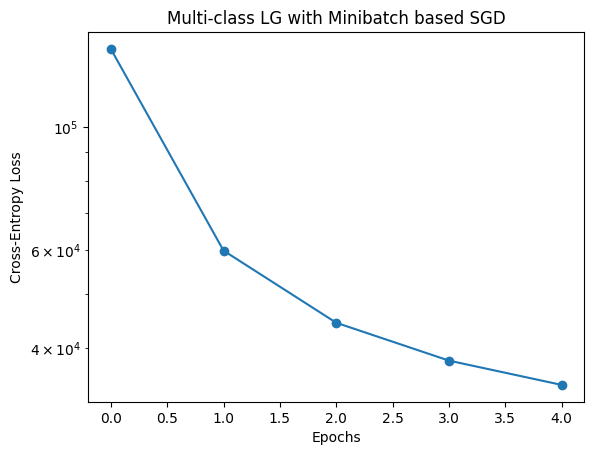

In [ ]:
def multiclassLogisticRegressionMiniBatchSGD(X, Y, eta, batch_size, n_epochs):
    #logistic regression based stochastic gradient descent
    N, d = X.shape

    X = np.insert(X, 0, 1, axis=1)  # augment the number of features by one column
    k = Y.shape[1]
    w = np.zeros((k, d+1))  # initialize the weight as a matrix vector
    loss = []
    for ep in range(n_epochs):
        l = eval_loss(X, Y, w)
        loss.append(l)
        # shuffle
        random_indices = np.random.permutation(N)  # shuffle sample
        X = X[random_indices]
        Y = Y[random_indices]
        for i in range(0, N, batch_size):
            dataIndex = [idx for idx in range(i, i+batch_size)]
            grad_Li = 0
            for idx in dataIndex:
                Xi = X[idx]
                Yi = Y[idx]
                qi = softmax(w @ Xi)  # probability vector
                grad_Li += np.outer(qi - Yi, Xi)  # np outer product
            w = w - (eta * grad_Li) / batch_size
    return w, loss

w_minibatch, loss = multiclassLogisticRegressionMiniBatchSGD(X_train, y_train, 0.01, 200, 5)
plt.semilogy(loss, marker='o')
plt.xlabel("Epochs")
plt.ylabel('Cross-Entropy Loss')
plt.title('Multi-class LG with Minibatch based SGD')
plt.show()


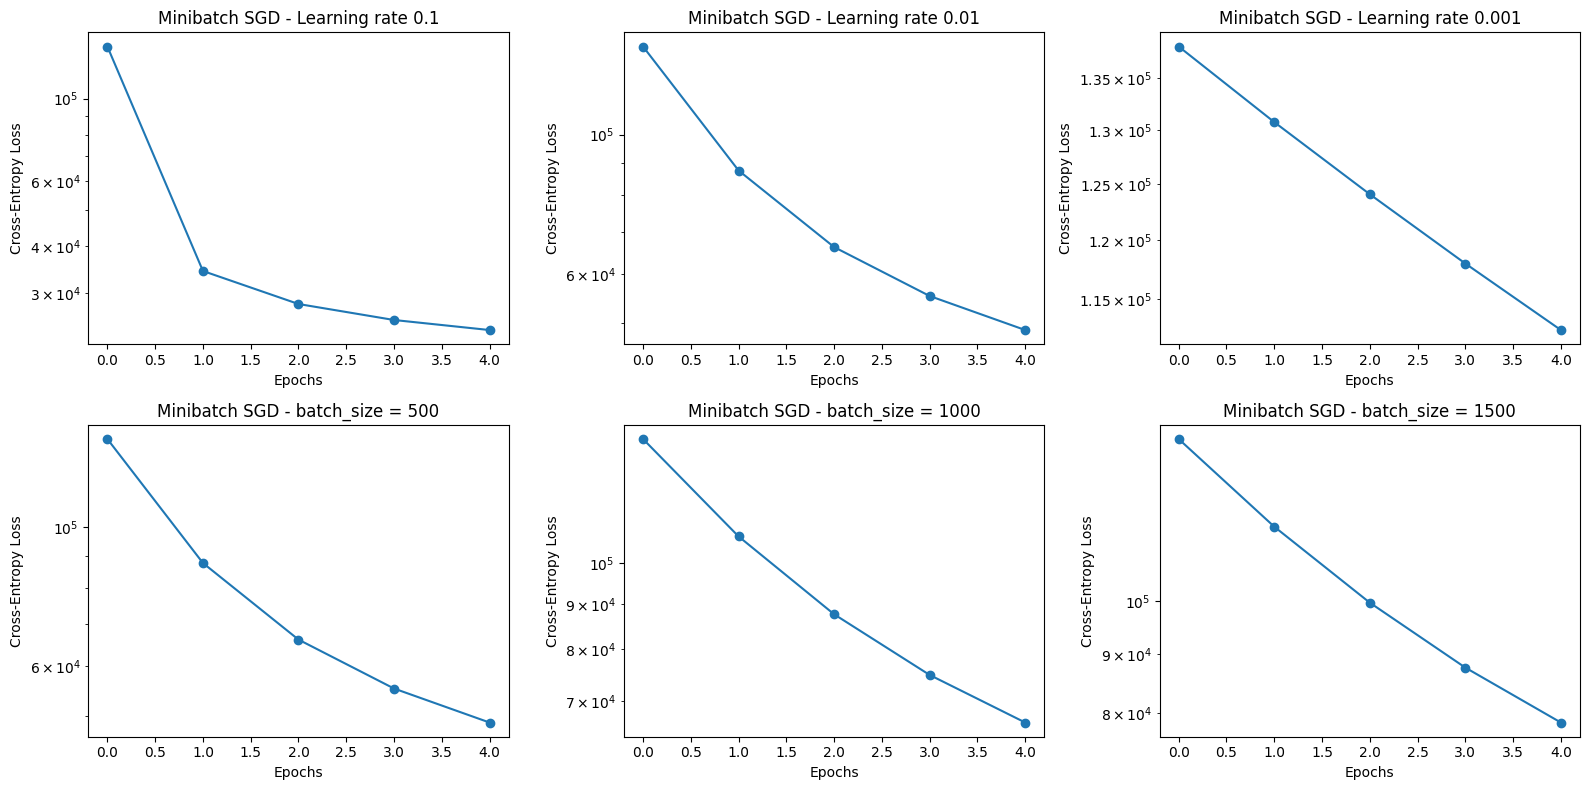

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

w, loss = multiclassLogisticRegressionMiniBatchSGD(X_train, y_train, 0.1, 500, 5)
ax[0, 0].semilogy(loss, marker='o')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Cross-Entropy Loss')
ax[0, 0].set_title('Minibatch SGD - Learning rate 0.1')

w, loss = multiclassLogisticRegressionMiniBatchSGD(X_train, y_train, 0.01, 500, 5)
ax[0, 1].semilogy(loss, marker='o')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Cross-Entropy Loss')
ax[0, 1].set_title('Minibatch SGD - Learning rate 0.01')

w, loss = multiclassLogisticRegressionMiniBatchSGD(X_train, y_train, 0.001, 500, 5)
ax[0, 2].semilogy(loss, marker='o')
ax[0, 2].set_xlabel('Epochs')
ax[0, 2].set_ylabel('Cross-Entropy Loss')
ax[0, 2].set_title('Minibatch SGD - Learning rate 0.001')

w, loss = multiclassLogisticRegressionMiniBatchSGD(X_train, y_train, 0.01, 500, 5)
ax[1, 0].semilogy(loss, marker='o')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Cross-Entropy Loss')
ax[1, 0].set_title('Minibatch SGD - batch_size = 500')

w, loss = multiclassLogisticRegressionMiniBatchSGD(X_train, y_train, 0.01, 1000, 5)
ax[1, 1].semilogy(loss, marker='o')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('Cross-Entropy Loss')
ax[1, 1].set_title('Minibatch SGD - batch_size = 1000')

w, loss = multiclassLogisticRegressionMiniBatchSGD(X_train, y_train, 0.01, 1500, 5)
ax[1, 2].semilogy(loss, marker='o')
ax[1, 2].set_xlabel('Epochs')
ax[1, 2].set_ylabel('Cross-Entropy Loss')
ax[1, 2].set_title('Minibatch SGD - batch_size = 1500')

plt.tight_layout()
plt.show()


Predictions

In [ ]:
predictions, probabilities = predict(X_test, w_minibatch)
print(len(predictions))
print(predictions[:10])
print (y_test[:10])

10000
[7, 2, 1, 0, 4, 1, 4, 9, 6, 9]
[7 2 1 0 4 1 4 9 5 9]


Accuracy

In [ ]:
numCorrect = 0
for i in range(N_test):
  if predictions[i] == y_test[i]:
    numCorrect +=1
accuracy = numCorrect/N_test

print("accuracy: " + str(accuracy))

accuracies["Minibatch_SGD"] = accuracy


accuracy: 0.9221


2. SGD momentum

Text(0.5, 1.0, 'Multi-class LG using Minibact SGD with Momentum')

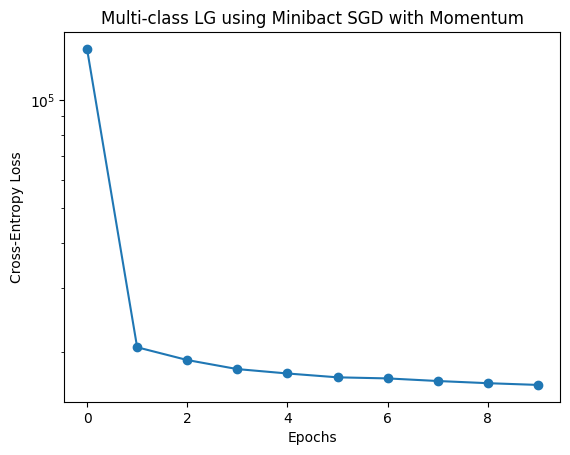

In [ ]:
def multiclassLogisticRegressionMiniBatchSGDWithMomentum(X, Y, eta, alpha, batch_size, n_epochs):
    #logistic regression based stochastic gradient descent
    # 0 < alpha < 1
    N, d = X.shape
    X = np.insert(X, 0, 1, axis = 1) # augment the number of features by one column
    k = Y.shape[1]
    w = np.zeros((k, d+1)) # initialize the weight as a matrix vector
    velocity = np.zeros((k, d+1)) # initialize the velocity

    loss = []
    for ep in range(n_epochs):
        l = eval_loss(X, Y, w)
        loss.append(l)
        # shuffle
        random_indices = np.random.permutation(N) # shuffle sample
        X = X[random_indices]
        Y = Y[random_indices]
        for i in range(0, N, batch_size):
            dataIndex = [idx for idx in range(i, i + batch_size)]
            grad_Li = 0
            for idx in dataIndex:
                Xi = X[idx]
                Yi = Y[idx]
                qi = softmax(w @ Xi) #probability vector
                grad_Li += np.outer(qi - Yi, Xi) #np outer product
            velocity = alpha * velocity - (eta * grad_Li) / batch_size
            w = w + velocity
    return w, loss

w_minibatchWithMomentum, loss = multiclassLogisticRegressionMiniBatchSGDWithMomentum(X_train, y_train, 0.9, 0.01, 500, 10)
plt.semilogy(loss, marker='o')
plt.xlabel("Epochs")
plt.ylabel('Cross-Entropy Loss')
plt.title('Multi-class LG using Minibact SGD with Momentum')

Minibatch SGD results with varying momentum showning varying speed of convergence

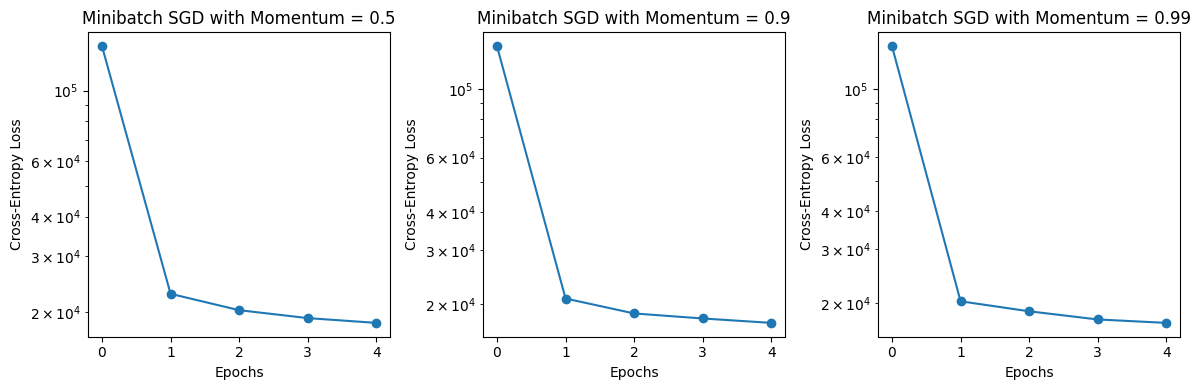

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

w, loss = multiclassLogisticRegressionMiniBatchSGDWithMomentum(x, y, 0.5, 0.01, 500, 5)
ax[0].semilogy(loss, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Cross-Entropy Loss')
ax[0].set_title('Minibatch SGD with Momentum = 0.5')

w, loss = multiclassLogisticRegressionMiniBatchSGDWithMomentum(x, y, 0.9, 0.01, 500, 5)
ax[1].semilogy(loss, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Cross-Entropy Loss')
ax[1].set_title('Minibatch SGD with Momentum = 0.9')

w, loss = multiclassLogisticRegressionMiniBatchSGDWithMomentum(x, y, 0.99, 0.01, 500, 5)
ax[2].semilogy(loss, marker='o')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Cross-Entropy Loss')
ax[2].set_title('Minibatch SGD with Momentum = 0.99')

plt.tight_layout()
plt.show()


In [ ]:
w_minibatchWithMomentum

array([[-0.55002352,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.43555637,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17811836,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.89902973,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.85573892,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.34848466,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

**Predictions**

In [ ]:
predictions, probabilities = predict(X_test, w_minibatchWithMomentum)
print(len(predictions))
print (predictions[:10])
print (y_test[:10])

10000
[7, 2, 1, 0, 4, 1, 4, 9, 6, 9]
[7 2 1 0 4 1 4 9 5 9]


Accuracy


In [ ]:
numCorrect = 0
for i in range(N_test):
  if predictions[i] == y_test[i]:
    numCorrect +=1
accuracy = numCorrect/N_test

print("accuracy: "+ str(accuracy))

accuracies["Minibatch_SGD_Momentum"] = accuracy


accuracy: 0.9221


Adam


In [ ]:
def multiclassLogisticRegressionAdam(X, Y, eta, beta1, beta2, batch_size, n_epochs, eps=1e-8):
    # logistic regression based stochastic gradient descent
    # 0 < beta1,beta2 < 1
    N, d = X.shape
    X = np.insert(X, 0, 1, axis = 1) # augment the number of features by one column
    k = Y.shape[1]
    w = np.zeros((k, d+1)) # initialize the weight as a matrix vector
    m = np.zeros((k, d+1)) # initialize the 1st moment vector
    v = np.zeros((k, d+1)) # initialize the 2nd moment vector

    loss = []
    for ep in range(n_epochs):
        l = eval_loss(X, Y, w)
        loss.append(l)
        # shuffle
        random_indices = np.random.permutation(N) # shuffle sample
        X = X[random_indices]
        Y = Y[random_indices]
        for i in range(0, N, batch_size):
            dataIndex = [idx for idx in range(i, i + batch_size)]
            grad_Li = 0
            for idx in dataIndex:
                Xi = X[idx]
                Yi = Y[idx]
                qi = softmax(w @ Xi) #probability vector
                grad_Li += np.outer(qi - Yi, Xi) #np outer product
            grad_Li /= batch_size
            m = beta1 * m + (1 - beta1) * grad_Li # update biased first moment estimate
            v = beta2 * v + (1 - beta2) * (grad_Li ** 2) # update biased second raw moment estimate
            m_hat = m / (1 - beta1 ** (ep + 1)) # compute bias-corrected first moment estimate
            v_hat = v / (1 - beta2 ** (ep + 1)) # compute bias-corrected second raw moment estimate
            w = w - eta * m_hat / (np.sqrt(v_hat) + eps) # update weights
    return w, loss


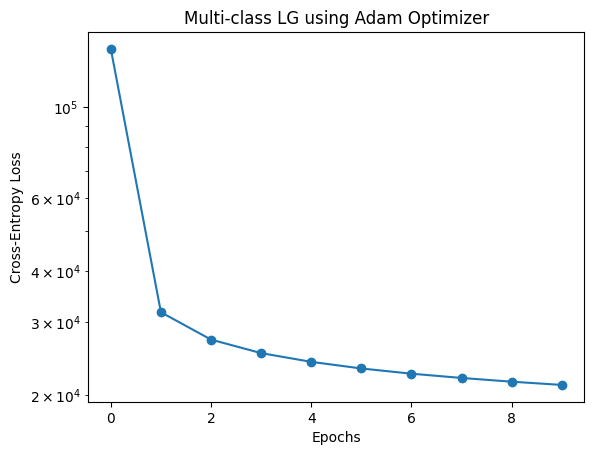

In [ ]:
w_adam, loss = multiclassLogisticRegressionAdam(X_train, y_train, 0.001, 0.9, 0.999, 500, 10)
plt.semilogy(loss, marker='o')
plt.xlabel("Epochs")
plt.ylabel('Cross-Entropy Loss')
plt.title('Multi-class LG using Adam Optimizer')
plt.show()


Predictions & Accuracy

In [ ]:
predictions, probabilities = predict(X_test, w_adam)
print(len(predictions))
print(predictions[:10])
print(y_test[:10])

numCorrect = 0
for i in range(N_test):
  if predictions[i] == y_test[i]:
    numCorrect +=1
accuracy = numCorrect/N_test
print("accuracy: " + str(accuracy))

accuracies["Adam"] = accuracy


10000
[7, 2, 1, 0, 4, 1, 4, 9, 6, 9]
[7 2 1 0 4 1 4 9 5 9]
accuracy: 0.9119


Results of accuracies for Comparison

In [ ]:
print("Accuracies: ", accuracies)

best_method = max(accuracies, key=accuracies.get)
print("Best method: ", best_method)


Accuracies:  {'SGD': 0.9221, 'Minibatch_SGD': 0.9221, 'Minibatch_SGD_Momentum': 0.9221, 'Adam': 0.9119}
Best method:  SGD


## ***DISCUSSION***

Given the observations acquired through the execution of this experiment, it's clear that the different optimization methods have variable influences on the performance of a neural network.

Upon analyzing the results of our experiments, we found that the optimizers Stochastic Gradient Descent (SGD), Minibatch SGD, and Minibatch SGD with Momentum each had a similar accuracy rate of 92.21%. This result indicates that these methods are highly efficient for the given task.

The Adam optimizer, on the other hand, showed a slightly lower accuracy rate of 91.19%. Although it's lower than the other methods, it is still a respectable accuracy considering the nature and difficulty of the task.

The experimental data ultimately points towards SGD as the best method among the ones we tested. This is due to its highest accuracy rate, simplicity, and overall efficiency.

In conclusion, this study provided valuable insights into the functioning and comparative efficiency of different optimization methods in the context of training a neural network. Further studies could focus on fine-tuning these methods or exploring new ones to see if there's a potential for even better performance.